# Coloring to preserve Computational Details:



In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import sys
import tempfile

import skimage.io as im_io

from PIL import TiffImagePlugin as tip
from PIL.TiffImagePlugin import Image

sys.path.insert(0, '../src/')
sys.path.insert(0, 'scalygraphic/src/')

from im_scale_products import *
from impute_color import *

# Compute
****
### Algebraic Vector Matrix Data: *EscapeTime, Z_initial, Z_final* (ET, Z0, Z)

In [2]:
results_dir = '../../results'
run_parameters = get_default_run_parameters(results_dir=None)
run_parameters['theta'] = np.pi / 2
if os.path.isdir(run_parameters['dir_path']) == False:
    os.makedirs(run_parameters['dir_path'])
    
fcn_name = 'nlC3'
eq = EQUS_DICT[EQUS_DICT_NAMED_IDX[fcn_name]][1]
# generate parameters:
# p = eq(1, None)

p = [0.106699281931, -1.446300888486, 0.763588120232]
print('Using Equation parameters:\n',p,'\n')

list_tuple = [(eq, (p))]

t0 = time.time()
ET_1, Z_1, Z0_1 = eq_iter.get_primitives(list_tuple, run_parameters)
tt = time.time() - t0
print(tt, 's\ndata matrices size = ', ET_1.shape)

Using Equation parameters:
 [0.106699281931, -1.446300888486, 0.763588120232] 

1.1917850971221924 s
data matrices size =  (256, 256)


## Useful examples -- *impute_color.py* functions
****
### View the raw escape time & distance data in greyscle:
* Note that most of the data is not easy to see because the extremes hog the black or white.
* Enumerated, normalized version below shows all three imputed with an HSV scheme.
### Naive method: normalize all to graphic floats in range (0, 1)

```python
def cat_im_list_hori(im_list):
    """ combine a list of images horizontaly 
    """
    h = 0
    w = 0
    for im in im_list:
        w += im.size[0]
        h = max(h, im.size[1])

    new_im = tip.Image.new('L', (w, h), color=0)
    start_col = 0
    for im  in im_list:
        end_col = start_col + im.size[0]
        box = (start_col, 0, end_col, h)
        new_im.paste(im, box)
        start_col = end_col + 1
        
    return new_im

new_im = cat_im_list_hori(im_list)

display(new_im)
```


In [3]:
# def cat_im_list_verti(im_list):
#     """ combine a list of images vertically 
#     """
#     h = 0
#     w = 0
#     for im in im_list:
#         h += im.size[1]
#         w = max(w, im.size[0])
        
#     new_im = tip.Image.new('L', (w, h), color=0)
#     start_row = 0
#     for im in im_list:
#         end_row = start_row + im.size[0]
#         box = (0, start_row, w, end_row)
#         new_im.paste(im, box)
#         start_row = end_row + 1
        
#     return new_im

             ET                            Zd                            Zr


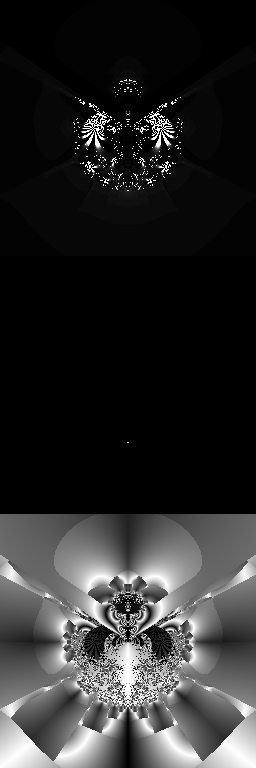

In [4]:
# complex result vectors == final minus initial
Z_vec = Z_1 - Z0_1

#                             normaize all to (0, 1)
# number of iterations
ET_n1 = graphic_norm(ET_1)
g_im_et = primitive_2_gray(ET_n1)
# complex result vectors: distance component
Zd_n1 = np.abs(Z_vec)
Zd_n1 = graphic_norm(Zd_n1)
g_im_Zd = primitive_2_gray(Zd_n1)

# complex result vectors: rotation component
Zr_n1 = np.arctan2(np.imag(Z_vec), np.real(Z_vec))
Zr_n1 = graphic_norm(Zr_n1)
g_im_Zr = primitive_2_gray(Zr_n1)

n_rows = np.shape(ET_1)[0]
n_cols = np.shape(ET_1)[1]

im_list = [g_im_et,g_im_Zd,g_im_Zr]
# new_im = cat_im_list_hori(im_list)
new_im = cat_im_list_verti(im_list)
print('%15s%30s%30s'%('ET','Zd','Zr'))
display(new_im)

### Problems with the Naive method:
    * Extremes pixel values mask the details in the softer regions


             ET                            Zd                            Zr


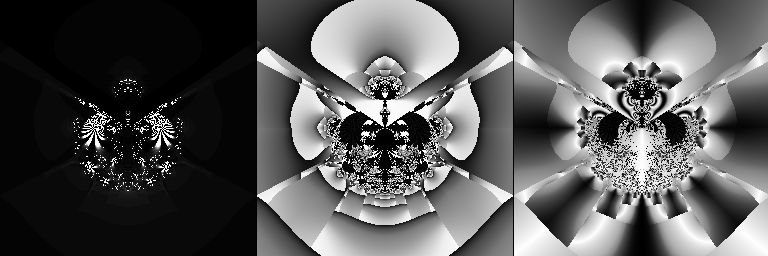

In [6]:
Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)

g_im_et = primitive_2_gray(ETn_n2)
# complex result vectors: distance component
g_im_Zd = primitive_2_gray(Zd_n2)

# complex result vectors: rotation component
g_im_Zr = primitive_2_gray(Zr_n2)

im_list = [g_im_et,g_im_Zd,g_im_Zr]
new_im = cat_im_list_hori(im_list)
#new_im = cat_im_list_verti(im_list)

print('%15s%30s%30s'%('ET','Zd','Zr'))
display(new_im)

### Much better visibility for the distance channel 


### Compositing all three makes a smooter image

In [ ]:
im_gray = get_gray_im(ET_1, Z_1, Z0_1)
display(im_gray)

In [ ]:
gray_array = np.array(im_gray)

g = gray_array.reshape(-1)
len(list(set(g)))

```python
import scipy.misc
img = scipy.misc.toimage(Zd_n2, mode='L')
display(img)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-26-e887f228efaf> in <module>
      1 import scipy.misc
----> 2 img = scipy.misc.toimage(Zd_n2, mode='L')
      3 display(img)

AttributeError: module 'scipy.misc' has no attribute 'toimage'

```

In [ ]:
n_rows = np.shape(ET_1)[0]
n_cols = np.shape(ET_1)[1]
Zd, Zr, ETn = etg_norm(Z0_1, Z_1, ET_1)

A = np.zeros((n_rows, n_cols, 3))
A[:,:,0] += ETn     # Hue
A[:,:,1] += Zr      # Saturation
A[:,:,2] += Zd      # Value

I = tip.Image.fromarray(np.uint8(A*255), 'HSV').convert('RGB')
# display(I)
# print(A.shape, type(A))
fname = 'test.tiff'
im_io.imsave(fname, A, plugin='tifffile')
if os.path.isfile(fname):
    print(fname, 'found')
# with tempfile.NamedTemporaryFile(suffix='.tiff') as tmp:
#     print(type(tmp), tmp, tmp.name)
#     print(os.path.isfile(tmp.name))
#     im_io.imsave(tmp.name, A)
#     #np.save(tmp, A)
#     #im_io.imsave(tmp.name, A)
#     #B = im_io.imread(tmp.name) #, as_gray=True)
#     #B2 = tip.Image.open(tmp.name)
#     #B2 = PIM.open(tmp.name)
#     B = im_io.imread(tmp.name)
    
# print(os.path.isfile(tmp.name))

# print(B.shape, type(B), type(B[0,0,0]))
# B_img = tip.Image.fromarray(B, 'HSV').convert('RGB')

# print('\n',type(B_img), B_img.size)
# display(B_img)
# display(I)

In [ ]:
help(ipd)

In [ ]:

g_im_et = primitive_2_gray(ET_1)
g_im_Zd = primitive_2_gray(np.abs(Z_1 - Z0_1))
Zv = Z_1 - Z0_1
Zv = np.arctan2(np.imag(Zv), np.real(Zv))
g_im_Zr = primitive_2_gray(Zv)


im_list = [g_im_et,g_im_Zd,g_im_Zr]
new_im = cat_im_list_hori(im_list)

print('%15s%30s%30s'%('ET','Zd','Zr'))
display(new_im)

In [ ]:
Zv = Z_1 - Z0_1

ET_f, n_colors = flat_index(ET_1)
g_im_et = primitive_2_gray(ET_f)

Zv_f, n_colors = flat_index(np.abs(Zv))
g_im_Zd = primitive_2_gray(Zv_f)


Zr = np.arctan2(np.imag(Zv), np.real(Zv))
Zr_f, n_colors = flat_index(Zr)
g_im_Zr = primitive_2_gray(Zr_f)


im_list = [g_im_et,g_im_Zd,g_im_Zr]
new_im = cat_im_list_hori(im_list)

print('%15s%30s%30s'%('ET','Zd','Zr'))
display(new_im)

In [ ]:
im = map_raw_etg(Z0_1, Z_1, ET_1, c_map_name='gist_gray')
display(im)

In [ ]:
im = get_gray_im(ET_1, Z_1, Z0_1)
display(im)

In [ ]:
show_color_maps()

In [ ]:
print('%s\n%s\n%s'%('ET','Zd','Zr'))
new_im = cat_im_list_verti(im_list)
display(new_im)

In [ ]:
g_im_et = primitive_2_gray(ET_1)

display(g_im_et)

In [ ]:
g_im_Zd = primitive_2_gray(np.abs(Z_1 - Z0_1))
display(g_im_Zd)

In [ ]:
# Zd_1, Zr_1, ETn_1 = etg_norm(Z0_1, Z_1, ET_1)
Zv = np.abs(Z_1 - Z0_1)
Zv = np.arctan2(np.imag(Zv), np.real(Zv))
g_im_Zr = primitive_2_gray(Zv)
# g_im = tip.Image.fromarray(Zv, 'L', colors=2**16-1)

display(g_im_Zr)

### View all results as an HSV (converted to RGB for display)
```python
# normalized enumeration of Z-Z0 distance, rotation (Zd, Zr) and Escape Time
Zd, Zr, ETn = etg_norm(Z0, Z, ET)

A = np.zeros((n_rows, n_cols,3))
A[:,:,0] += ETn     # Hue
A[:,:,1] += Zr      # Saturation
A[:,:,2] += Zd      # Value
```

In [ ]:
im = get_im(ET_1, Z_1, Z0_1)
display(im)

## Re-Compute
* *theta* rotates the domain before calculation
* Rotate to view symmetry with the broad part at the bottom - humans like that

In [ ]:
#                          Rotate the image for human readability:

run_parameters = get_default_run_parameters(results_dir=None)
run_parameters['theta'] = np.pi / 2

t0 = time.time()
ET, Z, Z0 = eq_iter.get_primitives(list_tuple, run_parameters)
tt = time.time() - t0

print(tt, 's\ndata matrices size = ', ET.shape)

## View The Rotated Data with different color assignments

In [ ]:
#                     HSV to RGB composite
im = get_im(ET, Z, Z0)
display(im)

In [ ]:
#                     HSV to RGB composite to Greyscale
im = get_gray_im(ET, Z, Z0)
display(im)

## Color map assignment to where greyscale is used as index to map
(choose color map from the list)

In [ ]:
show_color_maps(6)

In [ ]:
#                     HSV to RGB composite to Greyscale as index to colormap
do_im = map_etg_composite(Z0, Z, ET, c_map_name='afmhot')
display(do_im)

In [ ]:
do_im = map_etg_composite(Z0, Z, ET, c_map_name='gray')
display(do_im)

In [ ]:
do_im = map_etg_composite(Z0, Z, ET, c_map_name='nipy_spectral')
display(do_im)

In [ ]:
do_im = map_etg_composite(Z0, Z, ET, c_map_name='jet')
display(do_im)